# Example Model

## Setup Environment

In [1]:
from pathlib import Path, PurePath

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
DATASET_URL="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

## Training Data

### Prepare Dataset

In [34]:
data_file = Path(
    tf.keras.utils.get_file(
        "cats_and_dogs.zip",
        origin=DATASET_URL,
        extract=True,
    )
)

data_dir = data_file.parent / "cats_and_dogs_filtered"
train_dir = data_dir / "train"
validation_dir = data_dir / "validation"

Path.mkdir(data_dir, exist_ok=True)
Path.mkdir(train_dir, exist_ok=True)
Path.mkdir(validation_dir, exist_ok=True)

In [35]:
train_dataset__untuned = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

Found 2000 files belonging to 2 classes.


In [36]:
eval_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

eval_cardinality = tf.data.experimental.cardinality(eval_dataset)
test_dataset__untuned = eval_dataset.take(eval_cardinality // 5)
validation_dataset__untuned = eval_dataset.skip(eval_cardinality // 5)

Found 1000 files belonging to 2 classes.


### Configure Dataset

In [37]:
train_dataset = train_dataset__tuned.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE,
)

validation_dataset = validation_dataset__tuned.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE,
)

test_dataset = test_dataset__tuned.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE,
)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Explore Dataset

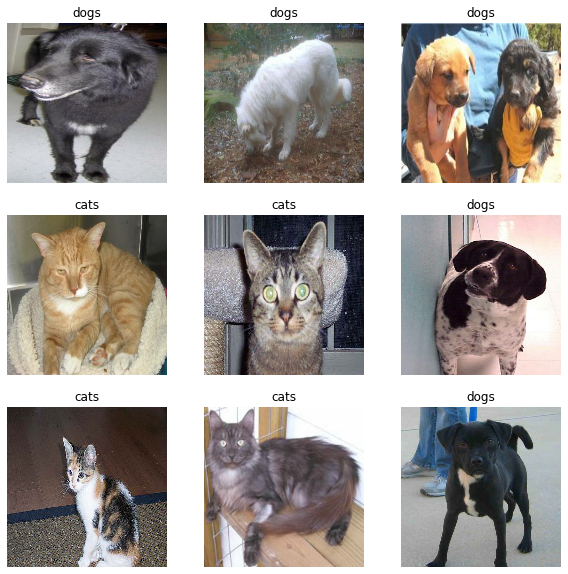

In [8]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_dataset.class_names[labels[i]])
        plt.axis("off")

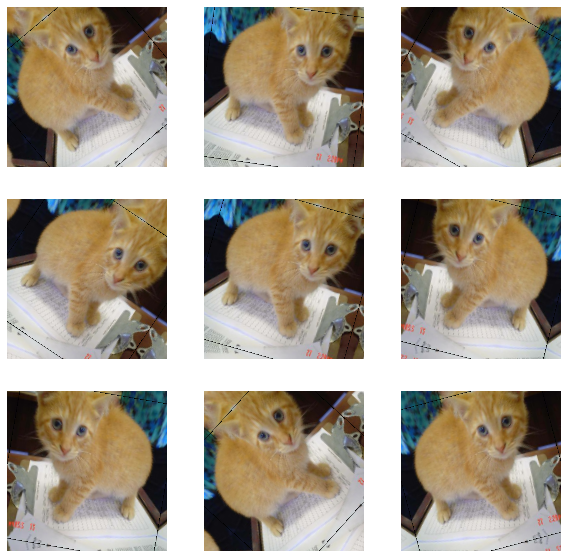

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

## Create Model

In [27]:
IMG_SHAPE = IMG_SIZE + (3,)
BASE_LEARNING_RATE = 0.0001
FINE_TUNING_RATE = 1e-5

### Feature Extractor

In [11]:
base_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 2560])

### Classification Head

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 2560])

In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

TensorShape([32, 1])

### Compile

In [18]:
model_inputs = tf.keras.Input(shape=IMG_SHAPE)
_x = data_augmentation(model_inputs)
_x = tf.keras.applications.efficientnet.preprocess_input(_x)
_x = base_model(_x, training=False)
_x = global_average_layer(_x)
_x = tf.keras.layers.Dropout(0.2)(_x)
model_outputs = prediction_layer(_x)
model = tf.keras.Model(model_inputs, model_outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=BASE_LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 5, 5, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense (Dense)                multiple                  2561      
Total params: 64,100,248
Trainable params: 2,561
Non-trainable params: 64,097,687
______________________________________

In [19]:
len(model.trainable_variables)

2

## Training

### Top layer

In [38]:
INITIAL_EPOCHS = 10

In [21]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.65
initial accuracy: 0.54


In [22]:
history = model.fit(
    train_dataset,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_dataset,
)

Epoch 1/10
63/63 [==============================] - 154s 2s/step - loss: 0.5815 - accuracy: 0.5915 - val_loss: 0.4815 - val_accuracy: 0.6708
Epoch 2/10
63/63 [==============================] - 154s 2s/step - loss: 0.4525 - accuracy: 0.7580 - val_loss: 0.3712 - val_accuracy: 0.8589
Epoch 3/10
63/63 [==============================] - 157s 2s/step - loss: 0.3838 - accuracy: 0.8450 - val_loss: 0.3038 - val_accuracy: 0.9208
Epoch 4/10
63/63 [==============================] - 162s 3s/step - loss: 0.3237 - accuracy: 0.8895 - val_loss: 0.2586 - val_accuracy: 0.9455
Epoch 5/10
63/63 [==============================] - 161s 3s/step - loss: 0.2899 - accuracy: 0.9010 - val_loss: 0.2238 - val_accuracy: 0.9567
Epoch 6/10
63/63 [==============================] - 161s 3s/step - loss: 0.2652 - accuracy: 0.9135 - val_loss: 0.2014 - val_accuracy: 0.9579
Epoch 7/10
63/63 [==============================] - 164s 3s/step - loss: 0.2432 - accuracy: 0.9145 - val_loss: 0.1818 - val_accuracy: 0.9641
Epoch 8/10
63

### Fine Tuning

In [33]:
FINE_TUNE_EPOCHS = 10

In [31]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(FINE_TUNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 5, 5, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense (Dense)                multiple                  2561      
Total params: 64,100,248
Trainable params: 63,789,521
Non-trainable params: 310,727
____________________________________

In [32]:
len(model.trainable_variables)

711

In [39]:
history__fine_tune = model.fit(
    train_dataset,
    epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
)

Epoch 10/20
63/63 [==============================] - 587s 9s/step - loss: 0.1272 - binary_accuracy: 0.9590 - val_loss: 0.0584 - val_binary_accuracy: 0.9814
Epoch 11/20
63/63 [==============================] - 531s 8s/step - loss: 0.0665 - binary_accuracy: 0.9745 - val_loss: 0.0494 - val_binary_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 511s 8s/step - loss: 0.0509 - binary_accuracy: 0.9855 - val_loss: 0.0400 - val_binary_accuracy: 0.9827
Epoch 13/20
63/63 [==============================] - 505s 8s/step - loss: 0.0483 - binary_accuracy: 0.9825 - val_loss: 0.0520 - val_binary_accuracy: 0.9802
Epoch 14/20
63/63 [==============================] - 545s 9s/step - loss: 0.0293 - binary_accuracy: 0.9925 - val_loss: 0.0411 - val_binary_accuracy: 0.9814
Epoch 15/20
63/63 [==============================] - 539s 9s/step - loss: 0.0212 - binary_accuracy: 0.9945 - val_loss: 0.0454 - val_binary_accuracy: 0.9765
Epoch 16/20
63/63 [==============================] - 549s 9s/ste

## Prediction

In [ ]:
x = model.predict(
    test_dataset
)

In [44]:
x

array([[ -9.516184 ],
       [ -8.06023  ],
       [ -9.89683  ],
       [-10.57098  ],
       [-11.308521 ],
       [  8.458745 ],
       [ -9.34623  ],
       [  8.745192 ],
       [-11.169344 ],
       [ 10.76146  ],
       [  4.2384357],
       [-10.291397 ],
       [  6.409971 ],
       [ 10.9100275],
       [ -9.782352 ],
       [  8.658614 ],
       [  8.738897 ],
       [ -7.5559797],
       [ -9.622478 ],
       [  9.732748 ],
       [ -8.417399 ],
       [-11.253914 ],
       [ -4.4146547],
       [-10.649569 ],
       [-10.5540695],
       [ -9.805889 ],
       [  5.7774944],
       [  9.523233 ],
       [  7.5051928],
       [  3.446495 ],
       [  7.3540134],
       [ -9.956314 ],
       [-11.424376 ],
       [ -9.363041 ],
       [  9.679396 ],
       [-10.611989 ],
       [  6.398059 ],
       [-11.098463 ],
       [ -7.5419436],
       [ -8.690342 ],
       [ -9.819296 ],
       [  8.388721 ],
       [ -1.161738 ],
       [  8.142719 ],
       [-10.315224 ],
       [ -

## References

* https://www.tensorflow.org/guide/keras/transfer_learning
* https://www.tensorflow.org/tutorials/images/transfer_learningBinaryCrossentropy